# Loan Prediction Problem

Dream Home Finance specializes in housing loans. Their branches are across rural, urban, and semi-urban. The company receives loan applications. Then, they evaluate whether each customer is eligible for a loan or not. The goal of this company is to use machine learning algorithms to predict the eligibility of new customers based on the information that they provide when they fill their application. Customers need to mention their Gender, Education, Marital Status, Number of Dependents, Credit History, Income, Loan Amount, etc.

The company has provided its data scientist with with a dataset to help him automate the process.

The dataset is available on kaggle in the following link:

https://www.kaggle.com/datasets/rishikeshkonapure/home-loan-approval

The dataframe has 614 instances, 12 features and one target variable

## List Of Contents

### 1. Import libraries, packages, and modules
### 2. Data collection and splitting
### 3. Data Exploration
### 4. Data Visualization
### 5. Data Cleaning
### 6. Feature Engineering
### 7. Testing different models
#### 7.1. Decision tress
#### 7.2. Logistic regression
#### 7.3. Bagging
### 8. Final model selection
### 9. Conclusion

## 1. Importing the packages

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.ensemble import BaggingClassifier

## 2. Data Collection and splitting

Let's load the dataframe and take a look at the first 5 observations

In [2]:
upload = files.upload()
files = list(upload.keys())[0]
df = pd.read_csv(files)
df.drop(columns = ['Loan_ID'], inplace = True)
df_train, df_test = train_test_split(df, test_size = 0.25, stratify = df['Loan_Status'], random_state = 40, shuffle = True)

Saving Loan.csv to Loan (6).csv


## 3. Data Exploration

### 3.1. Displaying the first 5 rows

In [3]:
df_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
39,Male,No,0,Not Graduate,No,3748,1668.0,110.0,360.0,1.0,Semiurban,Y
515,Male,Yes,3+,Graduate,No,3466,3428.0,150.0,360.0,1.0,Rural,Y
276,Male,Yes,0,Graduate,No,3993,3274.0,207.0,360.0,1.0,Semiurban,Y
583,Male,Yes,1,Graduate,No,1880,0.0,61.0,360.0,NaN,Rural,N
537,Male,No,2,Graduate,No,3617,0.0,107.0,360.0,1.0,Semiurban,Y


In the next cell, we check the types of data that we have

### 3.2. Checking the data types

In [4]:
print(df_train.dtypes)

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


The dataset has 5 numerical features and 6 categorical features. The target variable is 'Loan_Status' and it is categorical.

### 3.3. Checking for missing values

In [5]:
df_train.isnull().sum()

,0
Gender,5
Married,2
Dependents,11
Education,0
Self_Employed,28
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,21
Loan_Amount_Term,12
Credit_History,40


The dataset has some missing values to be handled later

# 4. Data Visualization

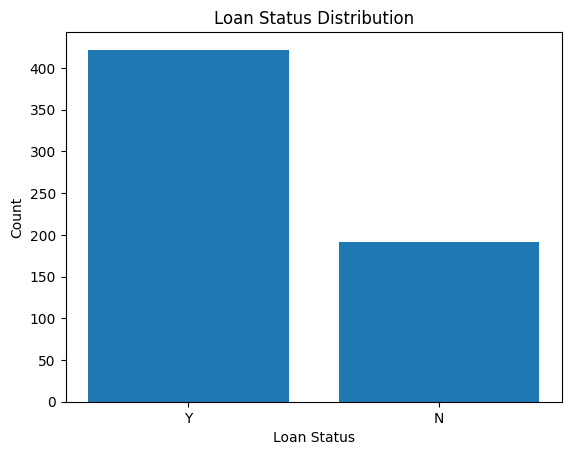

In [6]:
status_counts = df['Loan_Status'].value_counts()
plt.bar(status_counts.index, status_counts.values)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Distribution')
plt.show()

Our dataset has more than 400 eligible cusomers and only less than 200 customers not eligible for a loan.

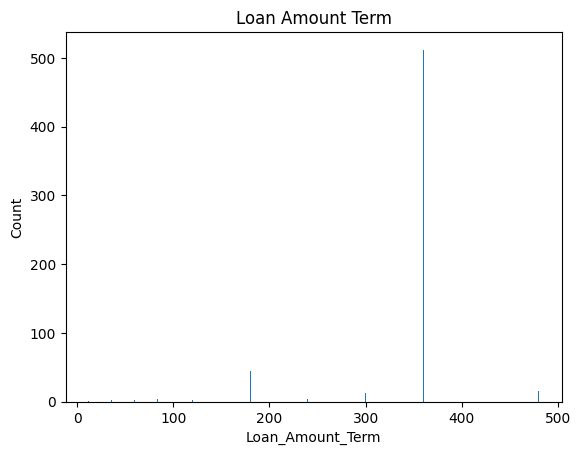

,count
Loan_Amount_Term,
360.0,512
180.0,44
480.0,15
300.0,13
240.0,4
84.0,4
120.0,3
60.0,2
36.0,2


In [7]:
status_counts = df['Loan_Amount_Term'].value_counts()
plt.bar(status_counts.index, status_counts.values)
plt.xlabel('Loan_Amount_Term')
plt.ylabel('Count')
plt.title('Loan Amount Term')
plt.show()
status_counts

From the graph above, we see that most customers have a loan_amount_term of three years

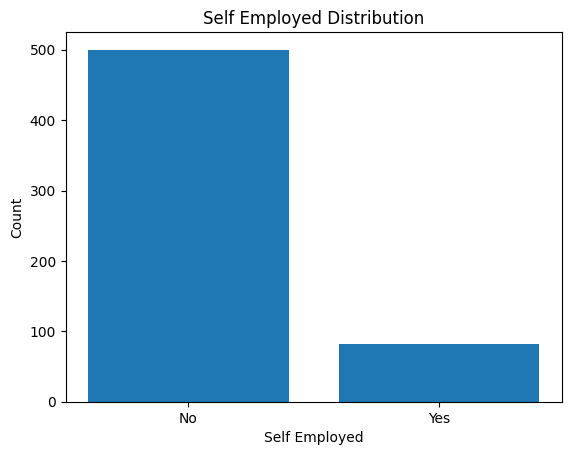

,count
Self_Employed,
No,500
Yes,82


In [8]:
status_counts = df['Self_Employed'].value_counts()
plt.bar(status_counts.index, status_counts.values)
plt.xlabel('Self Employed')
plt.ylabel('Count')
plt.title('Self Employed Distribution')
plt.show()
status_counts

Most of the target customers are not self employed

## 5. Data Cleaning

In the following cell, we replace missing values of each column with the mode.

In [9]:
for i in df_train:
    df_train[i].fillna(df_train[i].mode()[0], inplace = True)
    df_test[i].fillna(df_train[i].mode()[0],  inplace = True)

## 6. Feature Engineering

In the following cell, we define our X_train, y_train, X_test, and y_test

In [10]:
X_train = df_train.drop(columns = ['Loan_Status'])
y_train = df_train['Loan_Status']
X_test  = df_test.drop(columns = ['Loan_Status'])
y_test = df_test['Loan_Status']

### 6.1. OneHotEncoding

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first category to avoid multicollinearity
onehot_encoder.fit(X_train[categorical_features])
X_train_onehot_encoded = onehot_encoder.transform(X_train[categorical_features])
encoded_df = pd.DataFrame(X_train_onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))
X_train.reset_index(drop= True, inplace=True)
y_train.reset_index(drop= True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train[numerical_features], encoded_df], axis=1)


### 6.2. MinMax Scaling

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
X_test_onehot_encoded = onehot_encoder.transform(X_test[categorical_features])
encoded_df = pd.DataFrame(X_test_onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))
X_test.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test[numerical_features], encoded_df], axis=1)

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit(X_train)
X_train_scaled  = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 7. Testing Different Models

### 7.1. Decision Tree

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train, random_state = 40)

In [16]:
def g_mean(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Unpack confusion matrix components

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return np.sqrt(sensitivity * specificity)

g_mean_scorer = make_scorer(g_mean, greater_is_better=True)

In [17]:
from sklearn.metrics import recall_score, make_scorer, precision_score, classification_report, confusion_matrix
scorer = make_scorer(recall_score, pos_label = 'N')
param_grid = {"criterion": ["gini", "entropy"],
             "min_samples_split": [10, 20, 40],
             "max_depth": [2,3,4],
             "min_samples_leaf": [1,20, 40, 100],
             "max_leaf_nodes": [5,10,20]}

tree_model = DecisionTreeClassifier()
tree_grid = GridSearchCV(estimator = tree_model, param_grid = param_grid, scoring = g_mean_scorer, cv=10, verbose = 1)
search=tree_grid.fit(X_train, y_train)
best_tree = search.best_estimator_
y_train_pred = best_tree.predict(X_train)
y_val_pred  = best_tree.predict(X_val)

print("Best accuracy: {0:.2f}%".format(accuracy_score(y_train,y_train_pred)* 100))
print("Best Hyperparameters::\n{}".format(tree_grid.best_params_))
print("Validation accuracy: {0:.1f}%".format(accuracy_score(y_val,y_val_pred)* 100))
print("Classification report  \n %s" %(classification_report(y_val, y_val_pred)))
print(g_mean(y_val, y_val_pred))

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best accuracy: 80.29%
Best Hyperparameters::
{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 20, 'min_samples_split': 10}
Validation accuracy: 81.7%
Classification report  
               precision    recall  f1-score   support

           N       0.80      0.56      0.66        36
           Y       0.82      0.94      0.88        79

    accuracy                           0.82       115
   macro avg       0.81      0.75      0.77       115
weighted avg       0.82      0.82      0.81       115

0.7213832625817237


Now we normalize our dataset in order to improve the learning speed of SVM and logistic regression

## Tree visualization

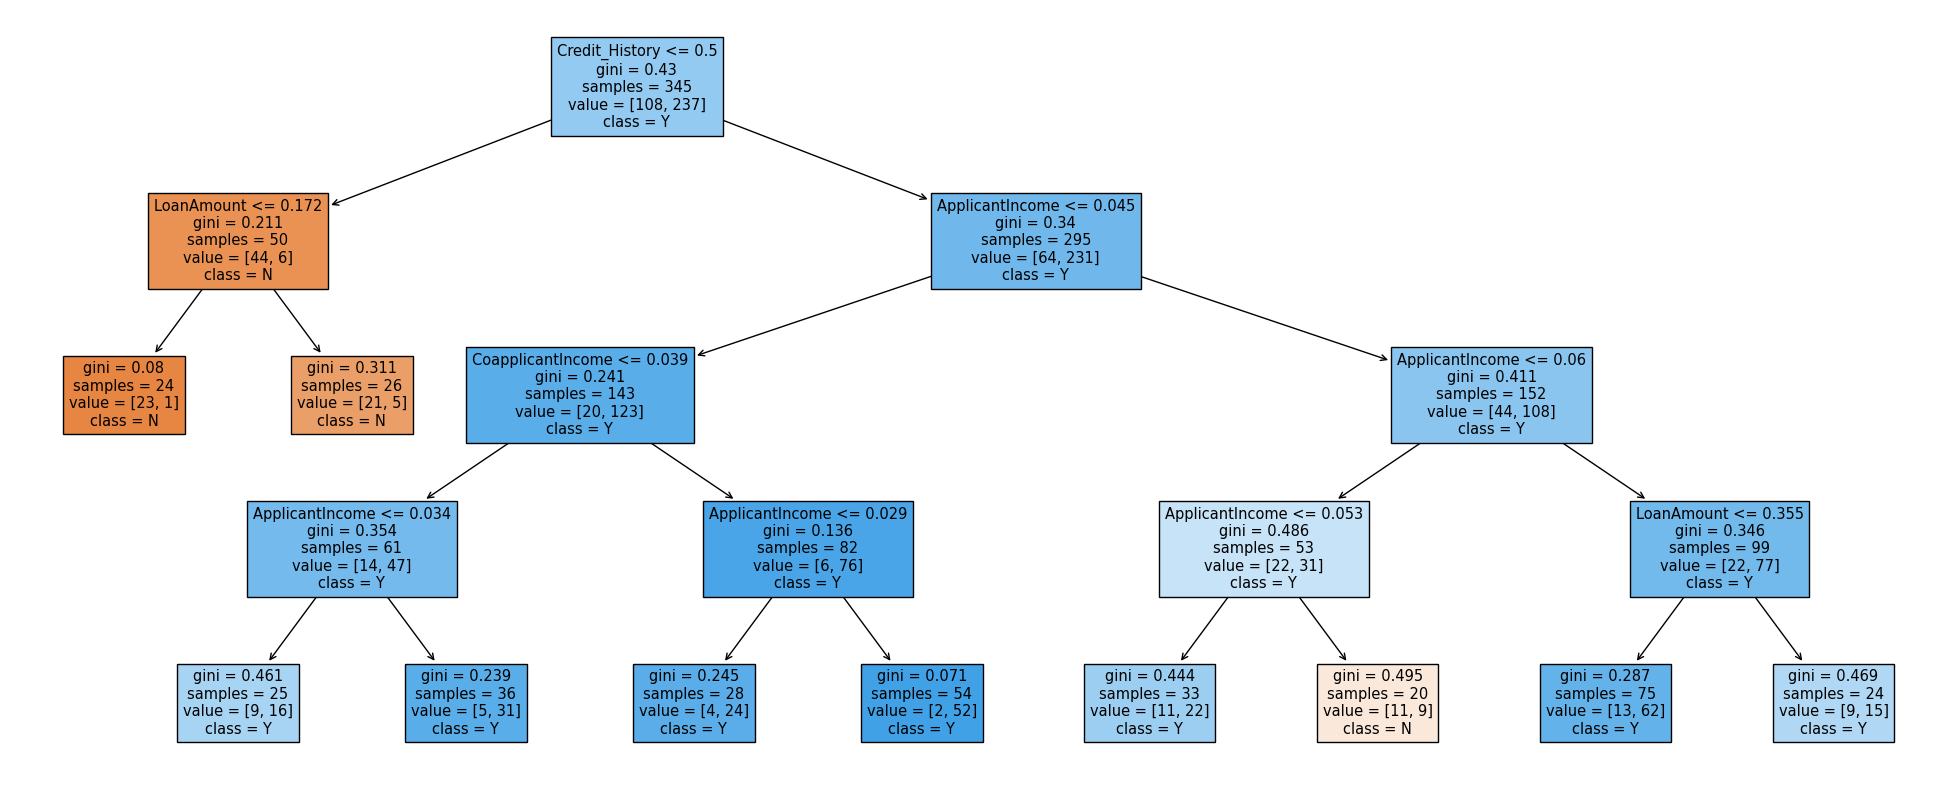

In [18]:
plt.figure(figsize=(25,10))
plot_tree(best_tree, filled=True, feature_names=X_train.columns, class_names=['N','Y'])
plt.show()

Based on the tree visualization, we conclude that Credit_History, ApplicantIncome, and CoapplicantIncome are the most important features, so we will work with only these features for the next algorithms

### 7.2. Logistic Regression

In [19]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

logistic_model = LogisticRegression(class_weight = 'balanced', max_iter=5000)

lg_grid_ = GridSearchCV(estimator=logistic_model, param_grid=param_grid, scoring = g_mean_scorer, cv=10)
lg_grid_.fit(X_train, y_train)
best_params = lg_grid_.best_params_
best_score = lg_grid_.best_score_
lg_best = lg_grid_.best_estimator_
lg_best.fit(X_train, y_train)
y_val_pred = lg_best.predict(X_val)
y_train_pred = lg_best.predict(X_train)
#test_score = accuracy_score(y_train, y_pred)

print("Best accuracy: {0:.2f}%".format(accuracy_score(y_train,y_train_pred)* 100))
print("Best Hyperparameters::\n{}".format(best_params))
print("Validation accuracy: {0:.1f}%".format(accuracy_score(y_val,y_val_pred)* 100))
print("Classification report  \n %s" %(classification_report(y_val, y_val_pred)))

Best accuracy: 73.62%
Best Hyperparameters::
{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
Validation accuracy: 77.4%
Classification report  
               precision    recall  f1-score   support

           N       0.62      0.69      0.66        36
           Y       0.85      0.81      0.83        79

    accuracy                           0.77       115
   macro avg       0.74      0.75      0.74       115
weighted avg       0.78      0.77      0.78       115



In [20]:
feature_importance_dict = dict( zip(X_train.columns, lg_best.coef_.tolist()[0]) )
feature_importance_dict

{'ApplicantIncome': 2.7089856463225117e-06,
 'CoapplicantIncome': -0.00017269402670343033,
 'LoanAmount': 0.00014242322603068996,
 'Loan_Amount_Term': -0.0019467544242108635,
 'Credit_History': 0.03245231896549729,
 'Gender_Male': 0.002128316960000988,
 'Married_Yes': 0.008631811934934357,
 'Dependents_1': -0.0033993782961607394,
 'Dependents_2': 0.004769799032947823,
 'Dependents_3+': 8.419843144681933e-05,
 'Education_Not Graduate': -0.00863197228703605,
 'Self_Employed_Yes': -0.0019686319666835997,
 'Property_Area_Semiurban': 0.009982102295878132,
 'Property_Area_Urban': -0.0026536041204660646}

### 7.3. Bagging

In [21]:
param_grid = {
    'n_estimators': [10, 50, 100, 200]
 #   'max_samples': [0.5, 0.75, 1.0],
  #  'max_features': [0.5, 0.75, 1.0]
  #  'bootstrap': [True, False],
  #  'bootstrap_features': [True, False]
}
bagging = BaggingClassifier(estimator=DecisionTreeClassifier())
bagging_search = GridSearchCV(estimator=bagging, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
bagging_search.fit(X_train, y_train)
best_model = bagging_search.best_estimator_
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_val_pred  = best_model.predict(X_val)
acc_train=accuracy_score(y_train,y_train_pred)
acc_test=accuracy_score(y_val,y_val_pred)
print("Training accuracy {0:.1f}%".format(acc_train*100))
print("Validation accuracy {0:.1f}%".format(acc_test*100))
print("Classification report  \n %s" %(classification_report(y_val, y_val_pred)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training accuracy 100.0%
Validation accuracy 80.0%
Classification report  
               precision    recall  f1-score   support

           N       0.76      0.53      0.62        36
           Y       0.81      0.92      0.86        79

    accuracy                           0.80       115
   macro avg       0.79      0.73      0.74       115
weighted avg       0.80      0.80      0.79       115



## 8. Final Model Selection

For our final model, we choose logistic regression because it had the best performance on the validation set. Thus, we run it on the test set.

In [22]:
y_test_pred = lg_best.predict(X_test)
print("Testing accuracy: {0:.1f}%".format(accuracy_score(y_test,y_test_pred)* 100))
print("Classification report  \n %s" %(classification_report(y_test, y_test_pred)))

Testing accuracy: 72.1%
Classification report  
               precision    recall  f1-score   support

           N       0.55      0.56      0.56        48
           Y       0.80      0.79      0.80       106

    accuracy                           0.72       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.72      0.72      0.72       154



## 9. Final Conclusion

For the final choice of our model, we choose to maximize the accuracy of the validation set as long as the recall of both classes is at least 50%. The best performing model was the logistic regression model with 77.4% on the validation set and 72.1% on the test set. According to the coefficients of logistic regression, the more the credit_score the more likely the customer is eligible. This is the most relevant feature based on coefficients found. According to the decision tree, if the credit score is 0, the customer is not eligible for a loan and he is eligible otherwise if certain conditions are met in the ApplicantIncome and CoapplicantIncome.